Machine Learning Assignment: Fraud Detection
This notebook applies Xgboost for binary classification using Python and pandas. The following steps are being covered:

- Data Loading
- Data Cleaning And Preparation
- EDA (dedicated notebook `Fraud_Detection_EDA.ipynb`)
- Feature Engineering
- Model Training (Cross Validation) and Evaluation
- Experiment tracking with MLflow - XGBoost as state of the art model
  - Baseline model
  - Features model
  - PCA model
  - time based split model
  - SMOTENC model (dedicated notebook `SMOTENC.ipynb`)
- Summary And Takeaways

Authors:

Guy Lissak, 201121126

Ron Kipnis, 207275371

### Login to Kaggle and download dataset

In [1]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
ieee_fraud_detection_path = kagglehub.competition_download('ieee-fraud-detection')

print('Data source import complete.')

100%|██████████| 118M/118M [00:01<00:00, 121MB/s]

Extracting files...


Data source import complete.


### Dependencies installation

In [3]:
!pip install mlflow pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00


In [5]:
from mlflow_client import start_mlflow_server, create_mlflow_experiment, start_ngrok_client

start_mlflow_server()
create_mlflow_experiment('XGboost Fraud Detection')
start_ngrok_client()

2025/03/17 19:54:31 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/17 19:54:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel "https://d249-34-59-216-168.ngrok-free.app" -> "http://127.0.0.1:5001"


### Plan of attack

1. First our strategy is to build a baseline model with only encoding categorical variables, without any new features or handling missing values.
2. We then apply the feature engineering we explored in the EDA section.
3. We then apply random search cross validation to find the best parametrs and pay attention to early stopping round and overfitting.
4. we will then run multiple experiments by trying mutliple modeling approaches.(ROC AUC will be our perforamnce metric for all the experiments, as required in this kaggle hackathon)
Each experiment will be logged to MLflow so we can present it in the hackthon presentation to simplify the visualization experiment.
5. Eventually we will upload the generated CSV test predictions to kaggle.
6. We will choose our champion model and evaluate it further and calibrate it.
7. Summary, takeaways and future imperovments.

### Baseline

[0]	validation_0-auc:0.84669	validation_1-auc:0.84166
[50]	validation_0-auc:0.95628	validation_1-auc:0.93354
[100]	validation_0-auc:0.97827	validation_1-auc:0.95289
[150]	validation_0-auc:0.98569	validation_1-auc:0.96008
[199]	validation_0-auc:0.98997	validation_1-auc:0.96396

Training AUC: 0.9900

Validation AUC: 0.9640
Diff 0.026004410499066877


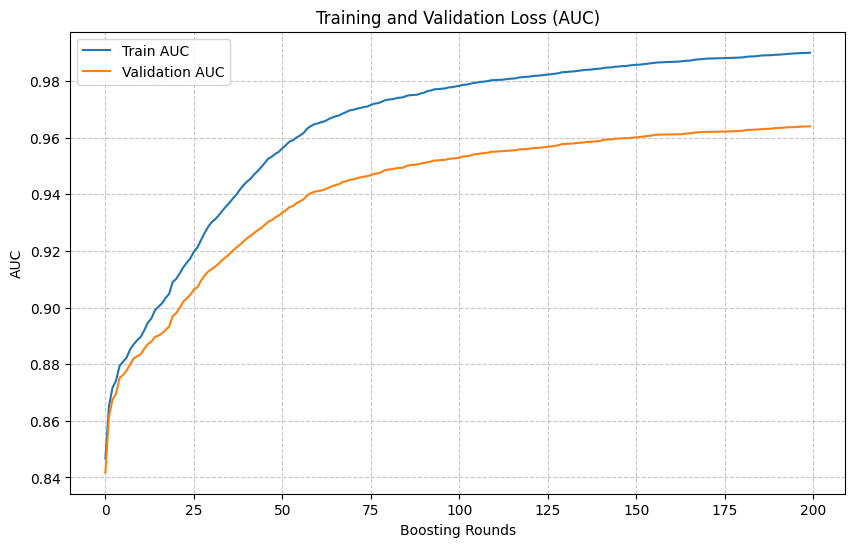

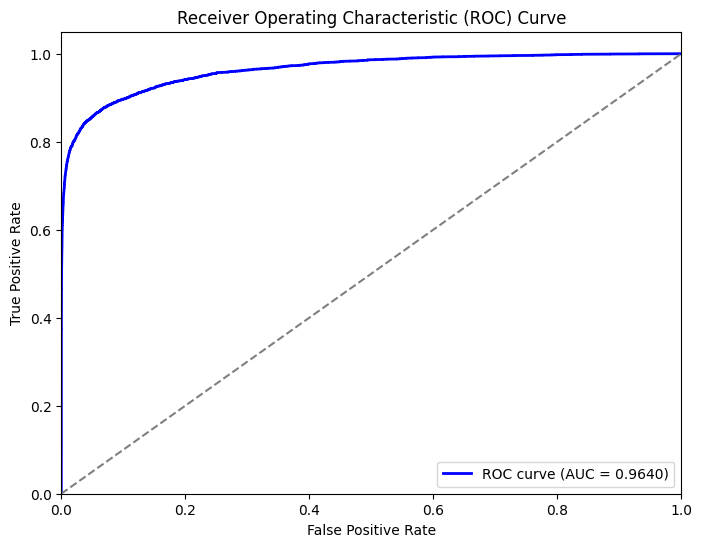

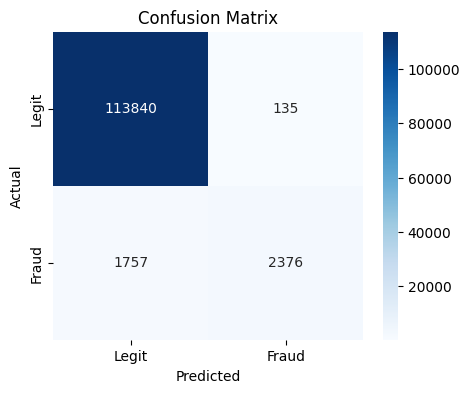

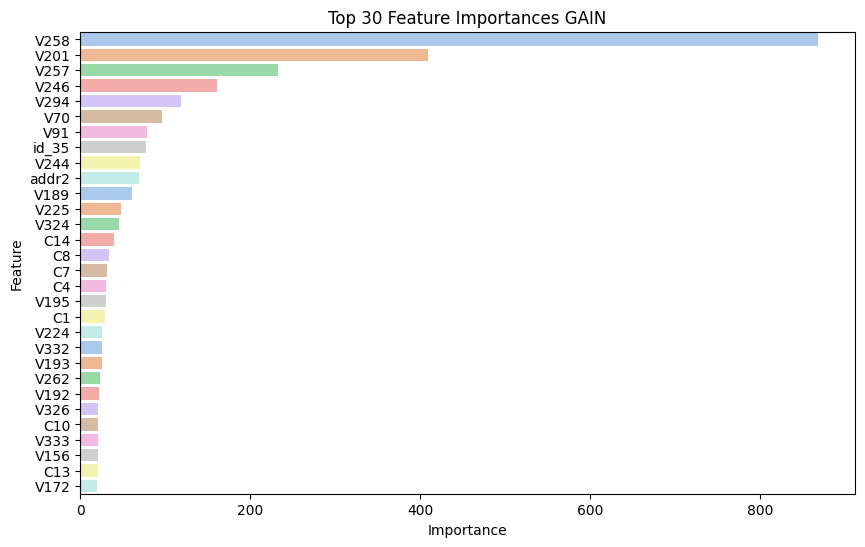

2025/03/17 20:06:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [15]:
from data_loader import load_raw_data, merge_datasets, get_data_dtypes
from data_preprocess import get_categorical_features, encode_categorical_features
from model_utils import prepare_data_for_training, train_model, evaluate_model, \
  export_test_predictions, log_mlflow_artifacts, prepare_data_for_training
import gc
import mlflow


xgb_model_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    "n_estimators":200,
    "max_depth":10,
    "learning_rate": 0.08,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}


with mlflow.start_run(run_name="MLflow baseline"):
  dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

  # Load raw data
  train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
      dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
  )

  # Merge datasets
  train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)
  dataset = mlflow.data.from_pandas(train)
  mlflow.log_input(dataset, context="training")

  del train_transaction, train_identity, test_transaction, test_identity
  gc.collect()

  # Prepare data for training
  X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test)
  # # Process categorical features
  categorical_features = get_categorical_features()
  X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

  # Get model parameters and train
  model_params = xgb_model_params
  model = train_model(X_train, X_val, y_train, y_val, model_params)

  # Evaluate model
  train_pred, train_auc = evaluate_model(model, X_train, y_train)
  print(f"\nTraining AUC: {train_auc:.4f}")
  val_pred, val_auc = evaluate_model(model, X_val, y_val)
  print(f"\nValidation AUC: {val_auc:.4f}")

  print(f"Diff {train_auc- val_auc}")

  log_mlflow_artifacts(model, model_params, train_auc, val_auc, val_pred, y_val, log_model=True)

  # Generate test predictions
  test_predictions = model.predict_proba(X_test)[:, 1]

  export_test_predictions(test_predictions, test)

- We can see that the AUC validation score is good (0.96), there's about 2.6% overfit between the training and validation, which indicates we have room to narrow the gap maybe with additonal calibration and features.

- The confusion matrix indicates that with 174 false positives, the model occasionally misclassifies legitimate transactions as fraud.
- The model has low recall at 0.5 threshold with 1757 false negative that the model detects as legit (meaning it misses a lot of fraud)

- From the feature importance we can see high population of V features being the most important which corraltes with our hypthesis from the EDA section.

### Cross Validation - Random Search

In this part we applied a random search cross validation to get the best hyper parameters. since the dataset is large we use GPU to improve the performance. the range was first tuned a little bit manually to get a high level feeling about the possible parameters that reduce overfitting.

In addition all the extra feature engineeing we explored in the EDA were applies in this part. (refer to function "run_feature_engineering")

In [54]:
from data_loader import load_raw_data, merge_datasets, get_data_dtypes
from data_preprocess import run_feature_engineering, encode_categorical_features, get_categorical_features
from model_utils import prepare_data_for_training
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import gc


dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

# Load raw data
train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
    dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
)

# Merge datasets
train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()


# Run feature engineering
train, test = run_feature_engineering(train, test)

# Prepare data for training
X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test, impute=True)
categorical_features = get_categorical_features()
X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

# Create the pipeline
pipeline = Pipeline([
    ('xgb', xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42
  ))
])


# Define hyperparameter search space
param_distributions = {
    'xgb__max_depth': list(range(4, 9)),
    'xgb__learning_rate': [0.05, 0.08, 0.065],
    'xgb__n_estimators': [200, 400, 600, 800],
    'xgb__subsample': [0.6, 0.8, 0.9],
    'xgb__colsample_bytree': [0.6, 0.8, 0.9],
    'xgb__reg_lambda': list(np.arange(4.0, 10.1, 1)),
    'xgb__reg_alpha':  list(np.arange(0.0, 2, 0.1)),
    'xgb__gamma': [0, 0.3, 0.5],
    'xgb__min_child_weight': [3, 5, 8, 10]
}

# RandomizedSearchCV with pipeline
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=3,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)


# Train RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get Best Params & Best Scores
best_params = random_search.best_params_
best_val_auc = random_search.best_score_

# Extract Train AUC
results = random_search.cv_results_
best_index = random_search.best_index_
best_train_auc = results["mean_train_score"][best_index]

print(f"🏆 Best Train AUC: {best_train_auc:.4f}")
print(f"🏆 Best Validation AUC: {best_val_auc:.4f}")
print(f"✅ Best Parameters: {best_params}")

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%
Fitting 5 folds for each of 50 candidates, totalling 250 fits
🏆 Best Train AUC: 0.9924
🏆 Best Validation AUC: 0.9625
✅ Best Parameters: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 10.0, 'xgb__reg_alpha': 0.0, 'xgb__n_estimators': 800, 'xgb__min_child_weight': 5, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.08, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.8}


We see a gap og almost 3% between the train and validation, this is expected because the random search CV measures the highest validation AUC. hence in the experiments we will investigate the overfit gap in earlier boosting rounds and experiment with lower number of n estimators.

### Experiments (all the experiment include the extra features that were added in the random search CV)
1. experiment 1 - 800 boosting rounds
2. experiment 2 - 220 boosting rounds
3. experiment 3 - PCA
4. experiment 4 - Time based split

#### Experiment 1 - extra feature engineering 800 n estimators

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%
[0]	validation_0-auc:0.81352	validation_1-auc:0.81304
[50]	validation_0-auc:0.92006	validation_1-auc:0.91031
[100]	validation_0-auc:0.93887	validation_1-auc:0.92568
[150]	validation_0-auc:0.95033	validation_1-auc:0.93403
[200]	validation_0-auc:0.95715	validation_1-auc:0.93893
[250]	validation_0-auc:0.96341	validation_1-auc:0.94390
[300]	validation_0-auc:0.96849	validation_1-auc:0.94735
[350]	validation_0-auc:0.97262	validation_1-auc:0.95028
[400]	validation_0-auc:0.97620	validation_1-auc:0.95303
[450]	validation_0-auc:0.97915	validation_1-auc:0.95530
[500]	validation_0-auc:0.98162	validation_1-auc:0.95687
[550]	validation_0-auc:0.98389	validation_1-auc:0.95866
[600]	validation_0-auc:0.98565	validation_1-auc:0.95983
[650]	validation_0-auc:0.98732	validation

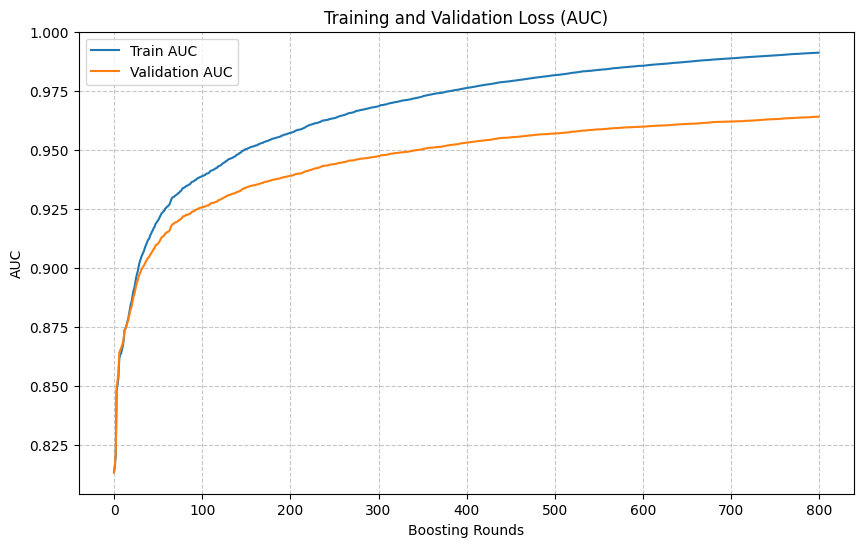

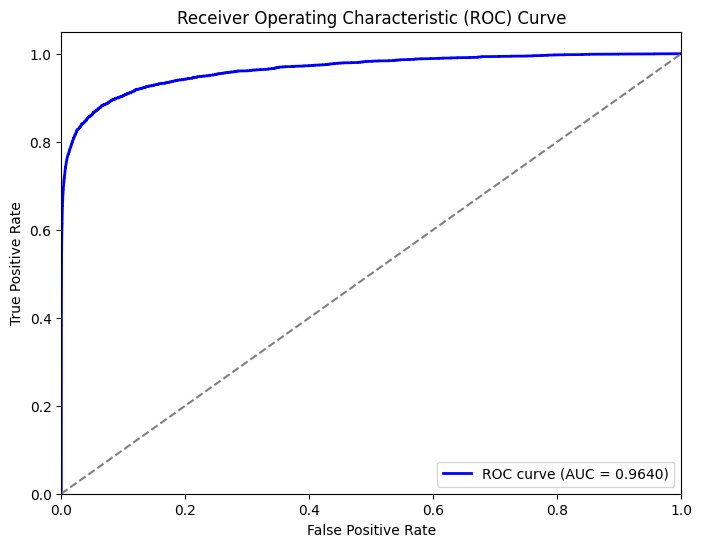

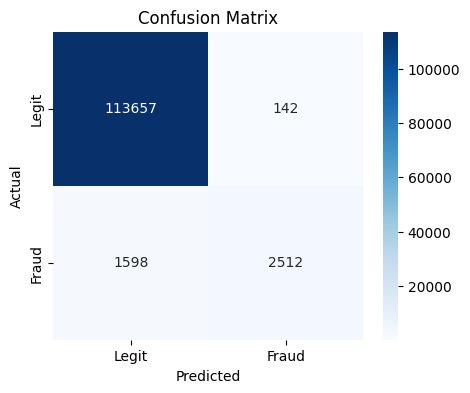

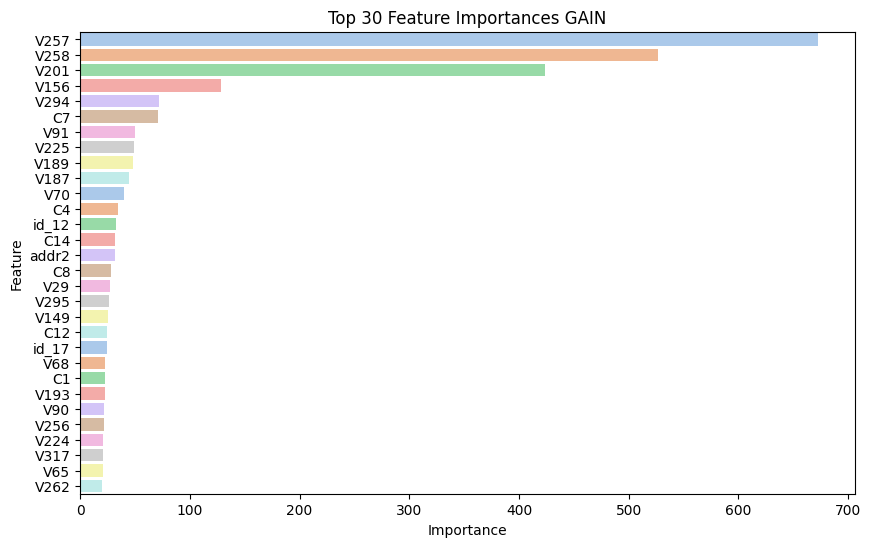

2025/03/17 20:14:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [17]:
import mlflow
import gc
from data_loader import load_raw_data, merge_datasets, get_data_dtypes
from data_preprocess import run_feature_engineering, encode_categorical_features, get_categorical_features
from model_utils import prepare_data_for_training, get_model_params, train_model, evaluate_model, \
  export_test_predictions, log_mlflow_artifacts



with mlflow.start_run(run_name="MLflow features 800 estimators"):
  dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

  # Load raw data
  train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
      dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
  )

  # Merge datasets
  train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)
  dataset = mlflow.data.from_pandas(train)
  mlflow.log_input(dataset, context="training")

  del train_transaction, train_identity, test_transaction, test_identity
  gc.collect()

  # Run feature engineering
  train, test = run_feature_engineering(train, test)

  # Prepare data for training
  X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test, impute=True)
  categorical_features = get_categorical_features()
  X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

  # Get model parameters and train
  model_params = get_model_params()
  model = train_model(X_train, X_val, y_train, y_val, model_params)

  # Evaluate model
  train_pred, train_auc = evaluate_model(model, X_train, y_train)
  print(f"\nTraining AUC: {train_auc:.4f}")
  val_pred, val_auc = evaluate_model(model, X_val, y_val)
  print(f"\nValidation AUC: {val_auc:.4f}")

  print(f"Diff {train_auc- val_auc}")

  log_mlflow_artifacts(model, model_params, train_auc, val_auc, val_pred, y_val, model_name="model_800_es", log_model=True)

  # Generate test predictions
  test_predictions = model.predict_proba(X_test)[:, 1]

  export_test_predictions(test_predictions, test, prefix="model_800")

- We can see that the AUC validation score is good (0.96), which is similar to baseline. there's about 2.7% overfit between the training and validation, however we can see from the AUC graph of train validation unlike the baseline in earlier rounds (200-300) the overfit is narrower and much better, hence we will try to choose 220 n estimators in the next experiment and see if narrower overfir graph can imperove the final score.


- The rest of the conclusions about the feature importance and confusion matrix are similar to the ones we discovered from the baseline evaluation.

#### Experiment 2 - reduce overfit, extra feature engineering 220 n estimators

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 220, 'learning_rate': 0.08, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.8, 'lambda': 10, 'alpha': 0}
[0]	validation_0-auc:0.81352	validation_1-auc:0.81304
[50]	validation_0-auc:0.92006	validation_1-auc:0.91031
[100]	validation_0-auc:0.93887	validation_1-auc:0.92568
[150]	validation_0-auc:0.95033	validation_1-auc:0.93403
[200]	validation_0-auc:0.95715	validation_1-auc:0.93893
[219]	validation_0-auc:0.96004	validation_1-auc:0.94104

Training AUC: 0.9600

Validation AUC: 0.9410
Diff 0.01900661416117977


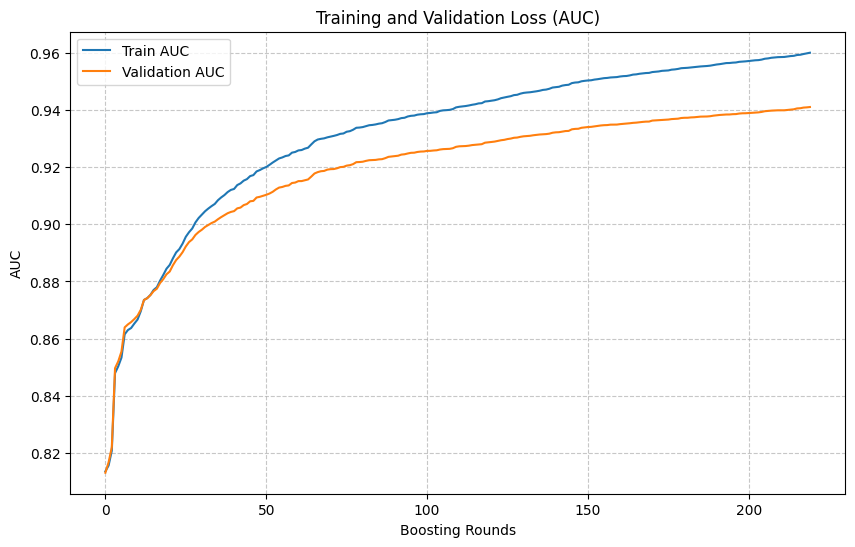

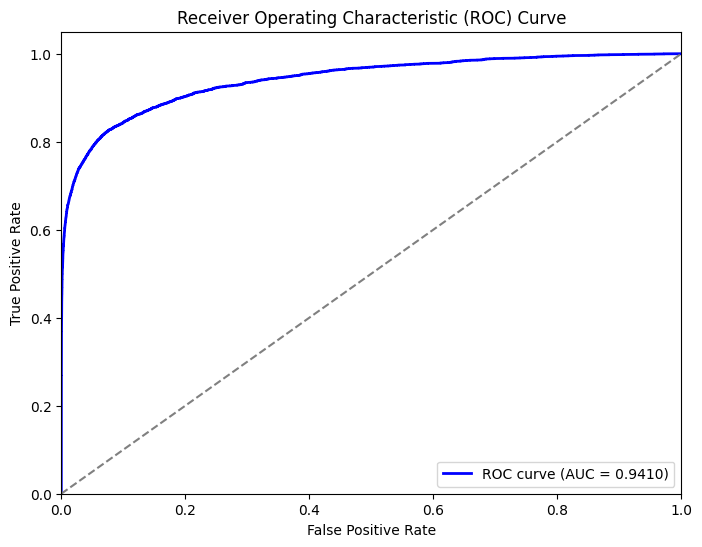

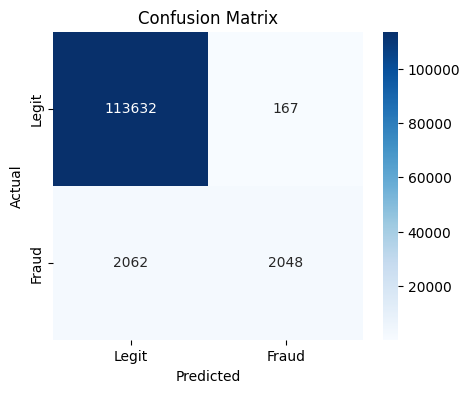

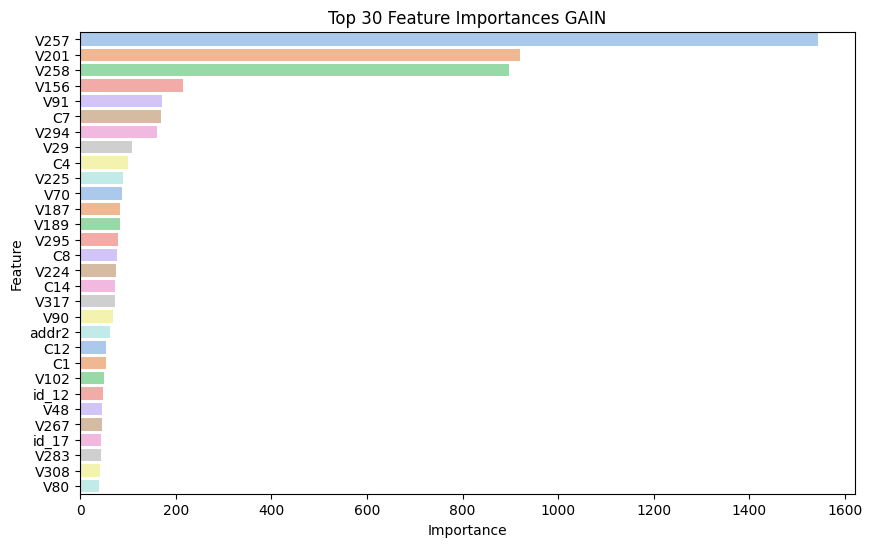

2025/03/17 20:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
import mlflow
import gc
from data_loader import load_raw_data, merge_datasets, get_data_dtypes
from data_preprocess import run_feature_engineering, encode_categorical_features, get_categorical_features
from model_utils import prepare_data_for_training, get_model_params, train_model, evaluate_model, \
  export_test_predictions, log_mlflow_artifacts


with mlflow.start_run(run_name="MLflow features 220 estimators"):
  dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

  # Load raw data
  train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
      dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
  )

  # Merge datasets
  train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)
  dataset = mlflow.data.from_pandas(train)
  mlflow.log_input(dataset, context="training")

  del train_transaction, train_identity, test_transaction, test_identity
  gc.collect()

  # Run feature engineering
  train, test = run_feature_engineering(train, test)

  # Prepare data for training
  X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test, impute=True)
  categorical_features = get_categorical_features()
  X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

  # Get model parameters and train
  model_params = get_model_params()
  model_params.update({"n_estimators": 220})
  print(model_params)
  model = train_model(X_train, X_val, y_train, y_val, model_params)

  # Evaluate model
  train_pred, train_auc = evaluate_model(model, X_train, y_train)
  print(f"\nTraining AUC: {train_auc:.4f}")
  val_pred, val_auc = evaluate_model(model, X_val, y_val)
  print(f"\nValidation AUC: {val_auc:.4f}")

  print(f"Diff {train_auc- val_auc}")

  log_mlflow_artifacts(model, model_params, train_auc, val_auc, val_pred, y_val, model_name="model_220_es", log_model=True)

  # Generate test predictions
  test_predictions = model.predict_proba(X_test)[:, 1]

  export_test_predictions(test_predictions, test, prefix="model_220")

As expected the overfitting graph looks much better now. it will be intersting to see the model performance against real test data and compare it with the prior model. the AUC validation is lower compared to others ~0.94 but still very good.

in terms of fraud recall, this model has more false negatives, but as we will explain in the calibration section AUC is threshold independant metric hence it doesn't mean a lot.

#### Experiment 3 - Extra feature engineering with PCA for V features.

V features have high-correlation clusters in the heatmap, as we see in the EDA section which indicate redundancy, offering opportunities for dimensionality reduction. Since the top feature importance are V features we decided to PCA all the V features but the top 6 V features.

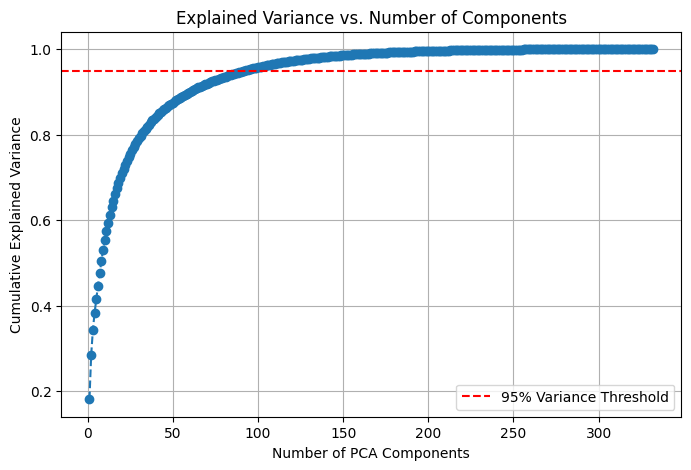

In [20]:
from model_utils import plot_pca_variance

plot_pca_variance(X_train, X_val, X_test)

The above graph shows the explained variance after doing PCA to V features only, without the top 6 V features. we can see that around 100 PCA components the explained variance is around 95%. we will use this number for our dimensions reduction,

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%
Keeping 6 top V features directly
Applying PCA to 332 remaining V features
Final feature count: 205 (original: 437)
PCA variance explained: 0.9577
[0]	validation_0-auc:0.81652	validation_1-auc:0.81696
[50]	validation_0-auc:0.92391	validation_1-auc:0.91125
[100]	validation_0-auc:0.94622	validation_1-auc:0.92776
[150]	validation_0-auc:0.95702	validation_1-auc:0.93490
[200]	validation_0-auc:0.96477	validation_1-auc:0.94002
[219]	validation_0-auc:0.96752	validation_1-auc:0.94147

Training AUC: 0.9675

Validation AUC: 0.9415
Diff 0.026052716090177674


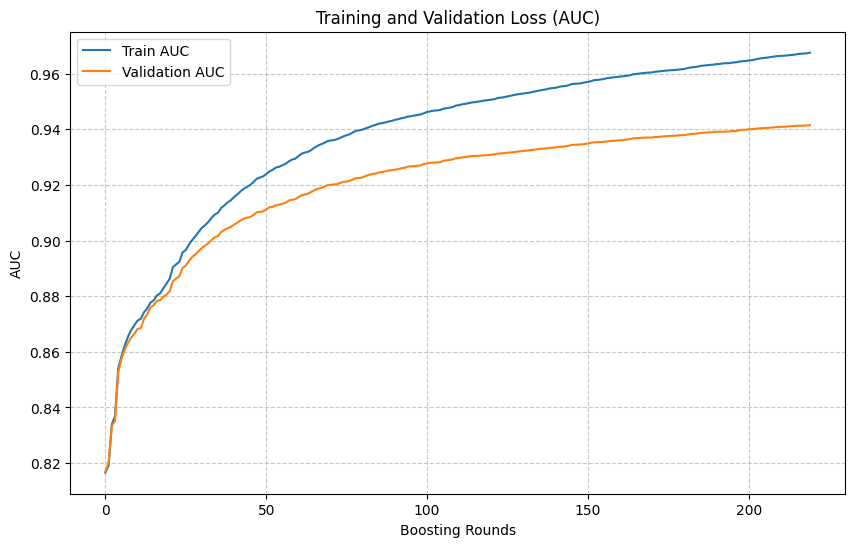

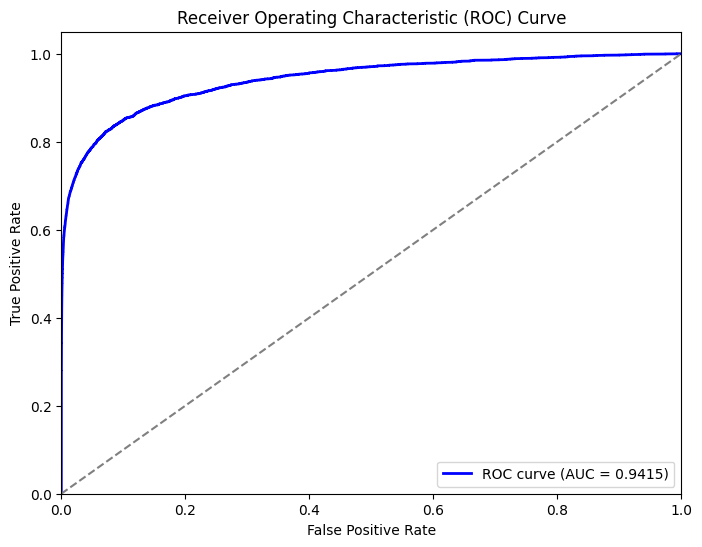

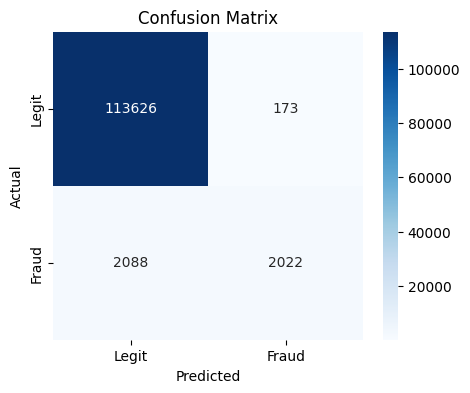

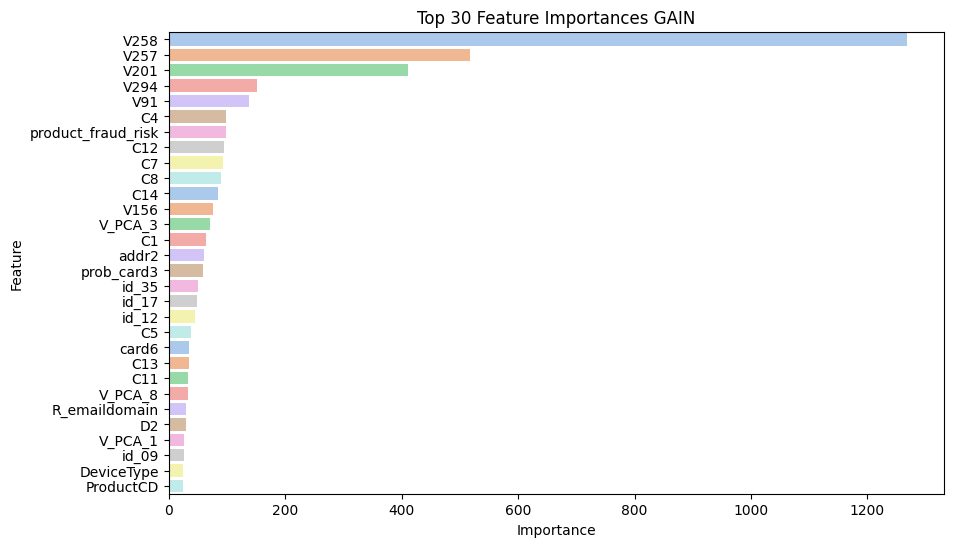

2025/03/17 20:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [21]:
import mlflow
import gc
from data_loader import load_raw_data, merge_datasets, get_data_dtypes
from data_preprocess import run_feature_engineering, get_categorical_features, encode_categorical_features
from model_utils import prepare_data_for_training, get_model_params, train_model, evaluate_model, \
  export_test_predictions, log_mlflow_artifacts, reduce_v_features_selectively


with mlflow.start_run(run_name="MLflow features with PCA"):
  dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

  # Load raw data
  train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
      dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
  )

  # Merge datasets
  train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)
  dataset = mlflow.data.from_pandas(train)
  mlflow.log_input(dataset, context="training")

  del train_transaction, train_identity, test_transaction, test_identity
  gc.collect()

  # Run feature engineering
  train, test = run_feature_engineering(train, test)

  # Prepare data for training
  X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test, impute=True)
  categorical_features = get_categorical_features()
  X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)
  X_train, X_val, X_test = reduce_v_features_selectively(X_train, X_val, X_test, n_components=100)

  # Get model parameters and train
  model_params = get_model_params()
  model_params.update({"n_estimators": 220})
  model = train_model(X_train, X_val, y_train, y_val, model_params)

  # Evaluate model
  train_pred, train_auc = evaluate_model(model, X_train, y_train)
  print(f"\nTraining AUC: {train_auc:.4f}")
  val_pred, val_auc = evaluate_model(model, X_val, y_val)
  print(f"\nValidation AUC: {val_auc:.4f}")

  print(f"Diff {train_auc- val_auc}")

  log_mlflow_artifacts(model, model_params, train_auc, val_auc, val_pred, y_val, model_name="model_pca", log_model=True)

  # Generate test predictions
  test_predictions = model.predict_proba(X_test)[:, 1]

  export_test_predictions(test_predictions, test, prefix="model_pca")

We can see that the validation AUC is pretty much around the validation AUC of the previous model with the 220 n estimators, however the overfit is bigger. corraltion matrix was not change a lot but in terms of feature importance we see more new features including our engineering features such as product_fraud_risk and prob_card3, which makes sense cause we reduced the V features.

#### Experiment 4 - time based split


Since our dataset is sorted in ascending order (with the smallest `TransactionDT` first), and our EDA has shown its significance, it's worth experimenting with training on future data instead of past data to prevent information leakage from future transactions. However, since this is a Kaggle competition with a fixed test dataset, and the model is already evaluated on future data, this approach is not strictly necessary. The final metrics will ultimately determine its impact.

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 220, 'learning_rate': 0.08, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.8, 'lambda': 10, 'alpha': 0}
[0]	validation_0-auc:0.80935	validation_1-auc:0.79364
[50]	validation_0-auc:0.92171	validation_1-auc:0.88763
[100]	validation_0-auc:0.94061	validation_1-auc:0.89876
[150]	validation_0-auc:0.95129	validation_1-auc:0.90670
[200]	validation_0-auc:0.95944	validation_1-auc:0.91117
[219]	validation_0-auc:0.96213	validation_1-auc:0.91268

Training AUC: 0.9621

Validation AUC: 0.9127
Diff 0.049449483715218845


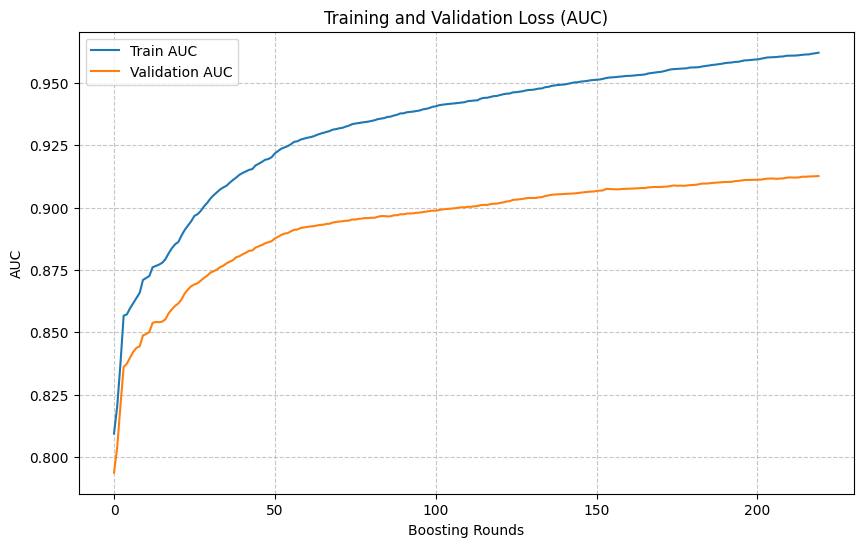

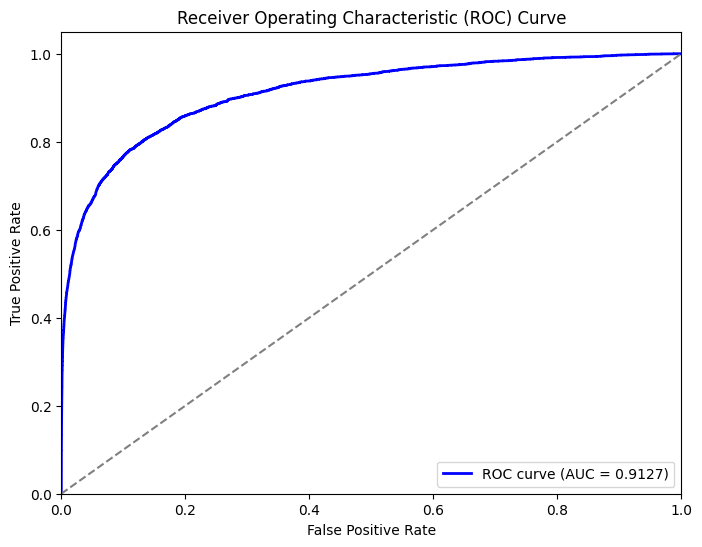

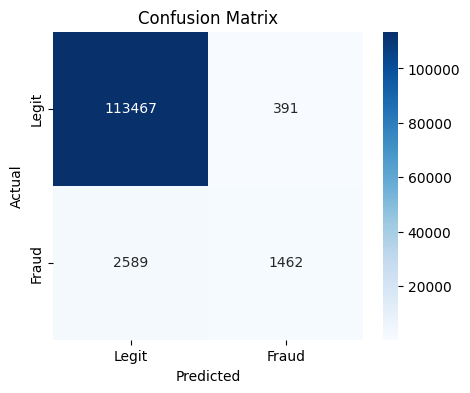

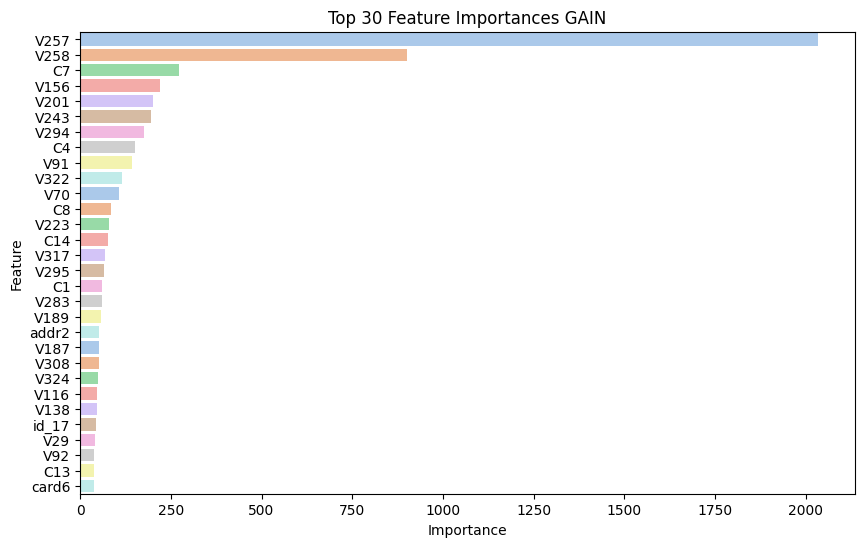

2025/03/17 20:38:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
import mlflow
import gc
from data_loader import load_raw_data, merge_datasets, get_data_dtypes
from data_preprocess import run_feature_engineering, encode_categorical_features, get_categorical_features
from model_utils import prepare_time_based_data_for_training, get_model_params, train_model, evaluate_model, \
  export_test_predictions, log_mlflow_artifacts


with mlflow.start_run(run_name="MLflow time based split"):
  dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

  # Load raw data
  train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
      dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
  )

  # Merge datasets
  train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)
  dataset = mlflow.data.from_pandas(train)
  mlflow.log_input(dataset, context="training")

  del train_transaction, train_identity, test_transaction, test_identity
  gc.collect()

  # Run feature engineering
  train, test = run_feature_engineering(train, test)

  # Prepare data for training
  X_train, X_val, y_train, y_val, X_test = prepare_time_based_data_for_training(train, test)
  categorical_features = get_categorical_features()
  X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

  # Get model parameters and train
  model_params = get_model_params()
  model_params.update({"n_estimators": 220})
  print(model_params)
  model = train_model(X_train, X_val, y_train, y_val, model_params)

  # Evaluate model
  train_pred, train_auc = evaluate_model(model, X_train, y_train)
  print(f"\nTraining AUC: {train_auc:.4f}")
  val_pred, val_auc = evaluate_model(model, X_val, y_val)
  print(f"\nValidation AUC: {val_auc:.4f}")

  print(f"Diff {train_auc- val_auc}")

  log_mlflow_artifacts(model, model_params, train_auc, val_auc, val_pred, y_val, model_name="model_time_based", log_model=True)

  # Generate test predictions
  test_predictions = model.predict_proba(X_test)[:, 1]

  export_test_predictions(test_predictions, test, prefix="model_time_based")

As we can see the validation AUC is the lowest so far and overfitting diff is the higher, the recall is also the worse with more false negatives in threshold of 0.5.

### Kaggle results

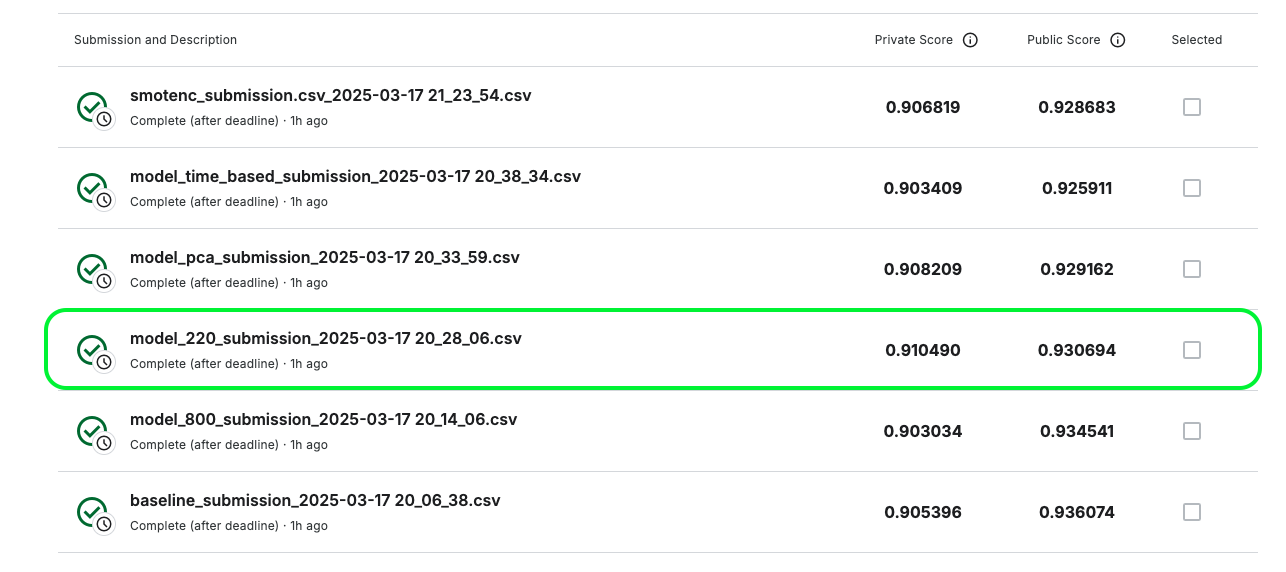

The kaggle results have matched our gutts, that the model with the lower overfit and extra features will have the best performance.
We must admit that the smotenc (refer to it's dedicated notebook) and the time based split model test results are suprising and higher than what we expected, but it can be explained that due to timing reason we didn't run cross validation on them.
Also in the real world we would probably choose model_220 and model_800 and run them as AB test. but since this is kaggle and closed test set, it's ok to get the score and see how our models perform.

### Calibration

In this part we will load one of the models, and investigate it further in terms of calibration. we have chose our best model `model_220_es`



We first load the model from MLflow registry, the power of MLflow!!! woo woo 💪
and run our compacted functions to just prepare the data with feature engineering and get our validation predictions.

since our code is wrapped in utils it's very simple 😀

In [23]:
import mlflow
run_id = "dc786f7d081a4e0a841310bf46272aca"
model_uri = f"runs:/{run_id}/model_220_es"

dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

# Load raw data
train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
    dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
)

# Merge datasets
train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

# Run feature engineering
train, test = run_feature_engineering(train, test)

# Prepare data for training
X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test, impute=True)
categorical_features = get_categorical_features()
X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)
loaded_model = mlflow.xgboost.load_model(model_uri)
val_pred, val_auc = evaluate_model(loaded_model, X_val, y_val)
print(f"\nValidation AUC: {val_auc:.4f}")

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%

Validation AUC: 0.9410


Next we plot the confusion matrix that we already saw during the model evaluation on the experiment part, and we will deep dive to the model precision and recall performances

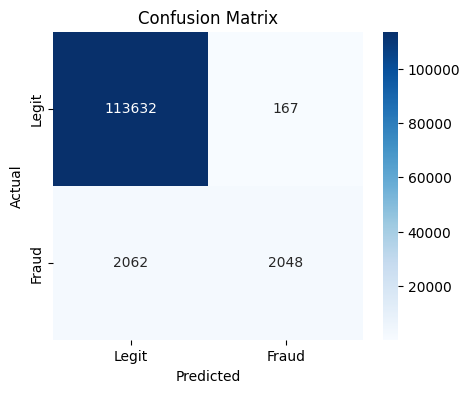

In [24]:
from model_utils import plot_confusion_matrix

plot_confusion_matrix(y_val, val_pred, True)

- True Negatives (113,632): Legitimate transactions correctly identified as non-fraud.
- False Positives (167): Legitimate transactions incorrectly flagged as fraud.
- False Negatives (2,062): Fraudulent transactions incorrectly classified as non-fraud.
- True Positives (2,048): Fraudulent transactions correctly identified as fraud.

Key Observations:

The model is highly accurate on non-fraud cases.
However, it misses many fraud cases (false negatives).

The model is slightly biased towards non-fraud predictions, likely due to class imbalance.

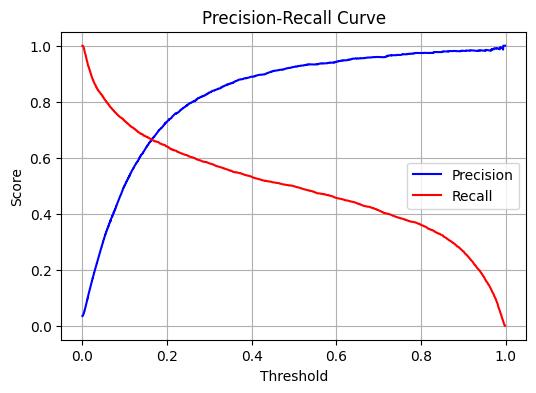

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_val, val_pred)
# Plot the curve
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()



This graph helps determine the best threshold for fraud detection by balancing precision (how many detected frauds are truly fraud) and recall (how many fraud cases we actually catch).

- Blue (Precision): How confident the model is when it predicts fraud. It improves as the threshold increases because the model makes fewer fraud predictions but with higher certainty.
- Red (Recall): The percentage of actual fraud cases the model correctly detects. It declines as the threshold increases because the model becomes stricter, predicting fraud less often.

Key Observations:

At low thresholds (~0.1), recall is high (detects most fraud cases), but precision is low (many false fraud flags).

At high thresholds (~0.7), precision is high (few false fraud flags), but recall is low (misses many frauds).

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_val, val_pred > 0.16))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113799
           1       0.66      0.67      0.66      4110

    accuracy                           0.98    117909
   macro avg       0.82      0.83      0.82    117909
weighted avg       0.98      0.98      0.98    117909



The part the line cross around 1.6 suggest the balance performance between recall to precision.

At 0.16 threshold, the model detects a reasonable amount of fraud (higher recall) while maintaining a decent precision.

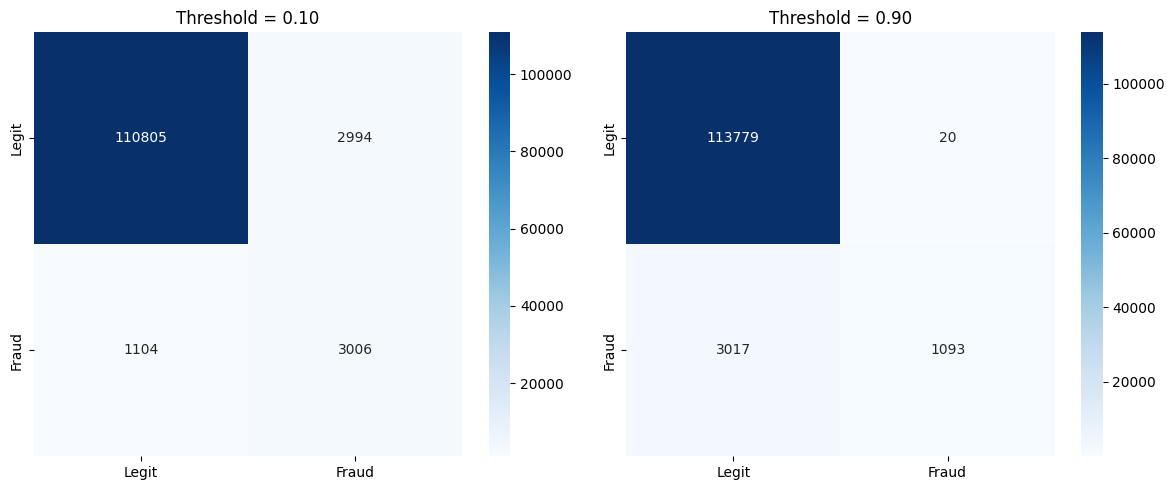

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define specific thresholds
thresholds = [0.1, 0.9]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, th in enumerate(thresholds):
    y_pred_adjusted = (val_pred >= th).astype(int)
    cm = confusion_matrix(y_val, y_pred_adjusted)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"], ax=axes[i])
    axes[i].set_title(f"Threshold = {th:.2f}")

plt.tight_layout()
plt.show()


$
   \text{Percision} = \frac{TP}{TP+FP}\
$ ;  $ \text{Recall} = \frac{TP}{TP+FN}\ $

Percision (fraud) = Of all transactions predicted as fraud, how many are actually fraud?

Recall (fraud) = Of all actual fraud cases, how many did we correctly detect?

!!! There is a tradeoff: Lowering the threshold increases fraud detection but also raises false positives. Increasing the threshold improves fraud confidence but misses fraud cases

Percision/ Recall th -> 0.1

In [28]:
tp = 3006
fp = 2994
fn = 1104
percision_01 = tp / (tp + fp)
recall_01 = tp / (tp + fn)
print(f"Percision: {percision_01}")
print(f"Recall: {recall_01}")

Percision: 0.501
Recall: 0.7313868613138687


Percision/ Recall th -> 0.9

In [29]:
tp = 1093
fp = 20
fn = 3017
percision_09 = tp / (tp + fp)
recall_09 = tp / (tp + fn)
print(f"Percision: {percision_09}")
print(f"Recall: {recall_09}")

Percision: 0.9820305480682839
Recall: 0.26593673965936737


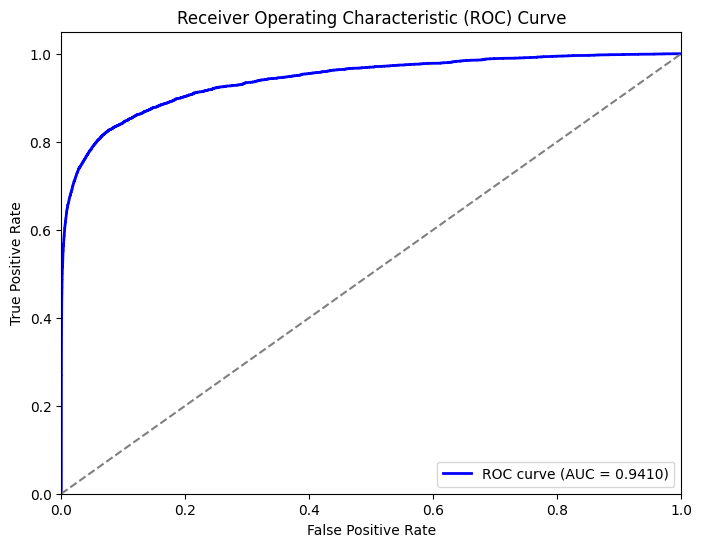

In [30]:
# import importlib
# import model_utils
# importlib.reload(model_utils)
from model_utils import plot_validation_roc_auc_curve

plot_validation_roc_auc_curve(val_pred, y_val, True)

AUC is threshold-independent (looks at the model's ability to distinguish fraud vs. non-fraud across all probability values).
Since AUC doesn't depend on a specific threshold, it shows the model's overall ranking ability rather than its exact classification performance at a chosen threshold.
The more the curve bends towards the top-left, the better the model is at separating fraud from legit transactions.

### MLFlow metrics

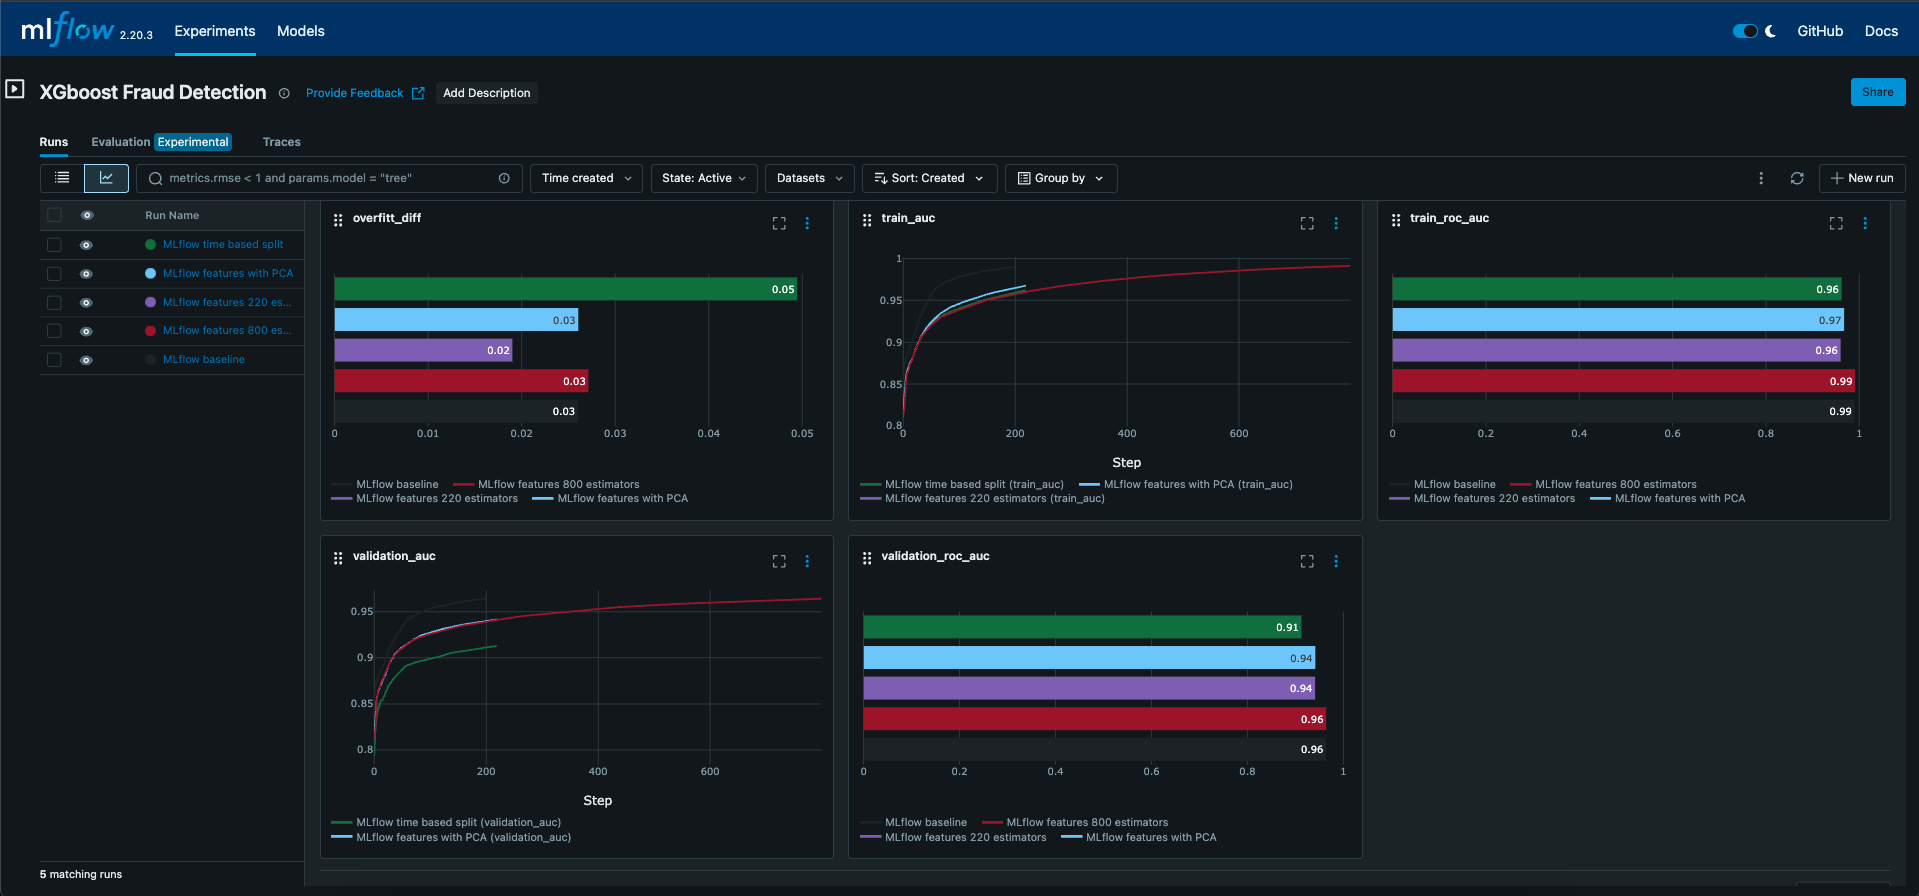

We have integrated MLflow to this project which help us for experiment tracking and model registry.
The above picture includes some of the metrics from all the experiments (baseline, model 800 n_estimators, model 220 n_estimators, pca model, time based split model).

As we can see the validation AUC of the baseline is the highest however the overfitting narrower gap is for "model 220" which eventually gives us the highest score in kaggle.

The time based split has the lower auc validation and widest overfit gap.

### Summary And Future Imperovments

In this Kaggle competition, we tackled a highly imbalanced fraud detection problem using advanced feature engineering, data preprocessing, and model optimization techniques. The dataset required handling missing values, categorical encoding, and balancing class distribution while preventing data leakage. We experimented with multiple modeling approaches and fine-tuned hyperparameters to maximize performance.

Throughout the process, we leveraged MLflow for experiment tracking, logged artifacts, and monitored model performance using key evaluation metrics such as AUC-ROC, Precision-Recall curves, and Confusion Matrices. Additionally, we explored time-based training splits to assess the impact of training on "future" vs. "past" transactions, as well as PCA dimenstion reduction and SMOTENC to balance the minority class.

#### Key Takeaways

✅ Feature Engineering
Derived time-based features (D1n, D15n, etc.), transaction-based attributes, and device-related insights significantly improved model performance.
PCA on selected V features helped reduce dimensionality while preserving important information.

✅ Handling Missing Values Properly
Numeric features were imputed using the mean, while categorical features were imputed with the most frequent value (mode).
A structured approach to dropping highly missing features prevented unnecessary noise.

✅ The model initially had high AUC (~0.94) but suffered from high false negatives (FN) at a default threshold of 0.5.
Adjusting the classification threshold improved recall at the cost of precision, emphasizing the need for business-driven decision-making.

✅ Model Selection & Hyperparameter Tuning
XGBoost performed well with GPU acceleration and fine-tuned hyperparameters.
In the trade of lower overfitting gap to higher AUC, the lower gap won.
Training stability was ensured by setting random seeds across preprocessing, train-test splitting, and model training.
Experiment Tracking & Reproducibility with MLflow

✅ Logging AUC curves, confusion matrices, and feature importance helped analyze model improvements over iterations.

#### Future work

- SMOTENC future research, we applied SMOTENC with increasing sample with ratio of 0.1 (see smotenc notebook), we had to run it on a dedicated strong machine because google collab didn't have enough RAM. we feel that there's still a lot of work that can be done in this area to reduce the overfitting and maybe beat the champion model

- Time based split, same for this, we didn't have much time to investigate the overfit, and if this were a real production use case, tunning a time based split model is crucial for imperovment

- Trying additional models, and ensamble models

- Try to detect clients rather than just transactions, we found that by combining some features such as card features, address features and D features we can identify clients with more than 1 transactions. calculating features around this can help, we didn't try it but this is something that worths trying for sure.